#II užduotis (Vieno neurono mokymas sprendžiant klasifikavimo uždavinį)

In [32]:
import csv, time
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
PATH = "/content/drive/MyDrive/breast+cancer+wisconsin+original/breast-cancer-wisconsin.data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# Duomenų įkėlimas ir paruošimas
def load_data(path: str):
    rows = []
    with open(path, "r") as f:
        for r in csv.reader(f):
            # atmetam eilutes su '?'
            if r and len(r) == 11 and "?" not in r[1:10]:
                rows.append(r)
    X, y = [], []
    for r in rows:
        feats = list(map(float, r[1:10]))  # be ID stulpelio
        lab = int(r[10])
        if lab == 2: y.append(0)   # 2 -> 0
        elif lab == 4: y.append(1) # 4 -> 1
        else: continue
        X.append(feats)
    X = np.array(X, dtype=float)
    y = np.array(y, dtype=float)

    idx = np.arange(len(X))
    np.random.shuffle(idx)
    return X[idx], y[idx]

X, y = load_data(PATH)

In [34]:
# 80:10:10 padalinimas (mokymas / validavimas / testas)
n = len(X)
n_train = int(0.8*n)
n_val   = int(0.1*n)
X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:], y[n_train+n_val:]

In [35]:
# Sigmoid, forward ir metrikos
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def forward(X, w, b):
    return sigmoid(X @ w + b)

def mse(y_true, y_hat):
    return np.mean((y_true - y_hat)**2)

def acc(y_true, y_prob):
    y_lab = (y_prob >= 0.5).astype(int)  # suapvalinimas į {0,1}
    return np.mean((y_lab == y_true).astype(float))

In [36]:
# 𝑤𝑘 ≔ 𝑤𝑘 − 𝜂 𝑦𝑖 − 𝑡𝑖 𝑦𝑖 (1 − 𝑦𝑖)(𝑥𝑖𝑘)
def train_sgd(X_tr, y_tr, X_va, y_va, lr=0.01, epochs=100, seed=0):
    rng = np.random.default_rng(seed)
    m, d = X_tr.shape
    w = rng.uniform(-0.01, 0.01, size=d)   # maži prad. svoriai
    b = rng.uniform(-0.01, 0.01)           # prad. bias

    tr_mse, va_mse, tr_acc, va_acc = [], [], [], []
    best_val_acc, best_val_mse = -1.0, float("inf")
    best_w, best_b, best_ep = w.copy(), float(b), 0
    t0 = time.time()

    for ep in range(epochs):
        # permaišom įrašus
        for i in rng.permutation(m):
            xi = X_tr[i]        # požymiai
            ti = y_tr[i]        # klasė

            ai = float(np.dot(w, xi) + b)   # a_i = w·x + b linijinė
            yi = 1.0 / (1.0 + np.exp(-ai))  # y_i = σ(a_i) sigmoidinė

            # (y_i - t_i) * y_i*(1 - y_i)
            gc = (yi - ti) * yi * (1.0 - yi) # bendroji gradiento dalis

            # Atnaujinimai pagal formules: w_k := w_k - η*gc*x_{ik},  b := b - η*gc
            for k in range(d):
                w[k] -= lr * gc * xi[k] # skaidrių taisyklė
            b -= lr * gc

        # metrikos po epochos
        ytr = forward(X_tr, w, b)
        yva = forward(X_va, w, b)
        tr_mse.append(mse(y_tr, ytr))
        va_mse.append(mse(y_va, yva))
        tr_acc.append(acc(y_tr, ytr))
        va_acc.append(acc(y_va, yva))

        # --- išsisaugom GERIAUSIĄ pagal VALIDAVIMO ACC (antrinis: mažesnis MSE) ---
        if (va_acc[-1] > best_val_acc) or (va_acc[-1] == best_val_acc and va_mse[-1] < best_val_mse):
            best_val_acc = va_acc[-1]
            best_val_mse = va_mse[-1]
            best_w, best_b, best_ep = w.copy(), float(b), ep

    t1 = time.time()
    return (w, b, np.array(tr_mse), np.array(va_mse), np.array(tr_acc), np.array(va_acc),
            (t1 - t0), best_w, best_b, best_val_acc, best_val_mse, best_ep)

In [37]:
# 𝑤𝑘 ≔ 𝑤𝑘 − 𝜂 𝑦𝑖 − 𝑡𝑖 𝑦𝑖 (1 − 𝑦𝑖)(𝑥𝑖𝑘)
def train_bgd(X_tr, y_tr, X_va, y_va, lr=0.01, epochs=100, seed=0):
    rng = np.random.default_rng(seed)
    m, d = X_tr.shape
    w = rng.uniform(-0.01, 0.01, size=d)
    b = rng.uniform(-0.01, 0.01)

    tr_mse, va_mse, tr_acc, va_acc = [], [], [], []
    best_val_acc, best_val_mse = -1.0, float("inf")
    best_w, best_b, best_ep = w.copy(), float(b), 0
    t0 = time.time()

    for ep in range(epochs):
        # Nulinam kaupiklius gradientui
        grad_w = np.zeros(d, dtype=float)
        grad_b = 0.0

        # kaupiam sumas: Σ_i (y_i - t_i) y_i(1 - y_i) * x_{ik}  ir  Σ_i (y_i - t_i) y_i(1 - y_i)
        for i in range(m):
            xi = X_tr[i]        # (d,)
            ti = y_tr[i]        # {0,1}

            ai = float(np.dot(w, xi) + b)
            yi = 1.0 / (1.0 + np.exp(-ai))

            gc_i = (yi - ti) * yi * (1.0 - yi)  # bendra dalis to įrašo

            for k in range(d):
                grad_w[k] += gc_i * xi[k]
            grad_b += gc_i

        # Apskaičiuojame vidurkius
        for k in range(d):
            grad_w[k] /= m
        grad_b /= m

        # atnaujinimas: w := w - η*∇w ,  b := b - η*∇b
        for k in range(d):
            w[k] -= lr * grad_w[k]
        b -= lr * grad_b

        # metrikos po epochos
        ytr = forward(X_tr, w, b)
        yva = forward(X_va, w, b)
        tr_mse.append(mse(y_tr, ytr))
        va_mse.append(mse(y_va, yva))
        tr_acc.append(acc(y_tr, ytr))
        va_acc.append(acc(y_va, yva))

        if (va_acc[-1] > best_val_acc) or (va_acc[-1] == best_val_acc and va_mse[-1] < best_val_mse):
            best_val_acc = va_acc[-1]
            best_val_mse = va_mse[-1]
            best_w, best_b, best_ep = w.copy(), float(b), ep

    t1 = time.time()
    return (w, b, np.array(tr_mse), np.array(va_mse), np.array(tr_acc), np.array(va_acc),
            (t1 - t0), best_w, best_b, best_val_acc, best_val_mse, best_ep)

In [44]:
# Paleidimas su baziniu LR
(w_sgd, b_sgd, tr_mse_sgd, va_mse_sgd, tr_acc_sgd, va_acc_sgd, time_sgd,
 best_w_sgd, best_b_sgd, best_val_acc_sgd, best_val_mse_sgd, best_ep_sgd) = train_sgd(X_train, y_train, X_val, y_val)

(w_bgd, b_bgd, tr_mse_bgd, va_mse_bgd, tr_acc_bgd, va_acc_bgd, time_bgd,
 best_w_bgd, best_b_bgd, best_val_acc_bgd, best_val_mse_bgd, best_ep_bgd) = train_bgd(X_train, y_train, X_val, y_val)

# Testas (abiejų metodų)
yprob_sgd_test = forward(X_test, w_sgd, b_sgd)
yprob_bgd_test = forward(X_test, w_bgd, b_bgd)
test_mse_sgd, test_acc_sgd = mse(y_test, yprob_sgd_test), acc(y_test, yprob_sgd_test)
test_mse_bgd, test_acc_bgd = mse(y_test, yprob_bgd_test), acc(y_test, yprob_bgd_test)

print("==== SGD (bazinis LR) ====")
print(f"Svoriai (9): {w_sgd}\nBias: {b_sgd}\nLaikas: {time_sgd:.3f} s")
print(f"Train MSE={tr_mse_sgd[-1]:.6f}, Train ACC={tr_acc_sgd[-1]:.4f}")
print(f"Val   MSE={va_mse_sgd[-1]:.6f}, Val   ACC={va_acc_sgd[-1]:.4f}")
print(f"Test  MSE={test_mse_sgd:.6f}, Test  ACC={test_acc_sgd:.4f}")

print("\n==== BGD (bazinis LR) ====")
print(f"Svoriai (9): {w_bgd}\nBias: {b_bgd}\nLaikas: {time_bgd:.3f} s")
print(f"Train MSE={tr_mse_bgd[-1]:.6f}, Train ACC={tr_acc_bgd[-1]:.4f}")
print(f"Val   MSE={va_mse_bgd[-1]:.6f}, Val   ACC={va_acc_bgd[-1]:.4f}")
print(f"Test  MSE={test_mse_bgd:.6f}, Test  ACC={test_acc_bgd:.4f}")

print(f"\nBest-by-val (SGD): ACC={best_val_acc_sgd:.4f}, MSE={best_val_mse_sgd:.6f}, epocha={best_ep_sgd}")
print(f"Best-by-val (BGD): ACC={best_val_acc_bgd:.4f}, MSE={best_val_mse_bgd:.6f}, epocha={best_ep_bgd}")

==== SGD (bazinis LR) ====
Svoriai (9): [ 0.1216755   0.352519    0.13731555  0.09472642 -0.10857652  0.34466897
 -0.06067501  0.2444796   0.09409844]
Bias: -3.956660797834464
Laikas: 0.486 s
Train MSE=0.027111, Train ACC=0.9670
Val   MSE=0.043481, Val   ACC=0.9559
Test  MSE=0.015172, Test  ACC=0.9855

==== BGD (bazinis LR) ====
Svoriai (9): [-0.04283657  0.04833887  0.03361447  0.01739508 -0.03009885  0.08319211
 -0.02417839  0.04663496 -0.02151289]
Bias: -0.0480719816676551
Laikas: 0.435 s
Train MSE=0.198054, Train ACC=0.7454
Val   MSE=0.198490, Val   ACC=0.7794
Test  MSE=0.197974, Test  ACC=0.7246

Best-by-val (SGD): ACC=0.9559, MSE=0.038653, epocha=97
Best-by-val (BGD): ACC=0.7794, MSE=0.198490, epocha=99


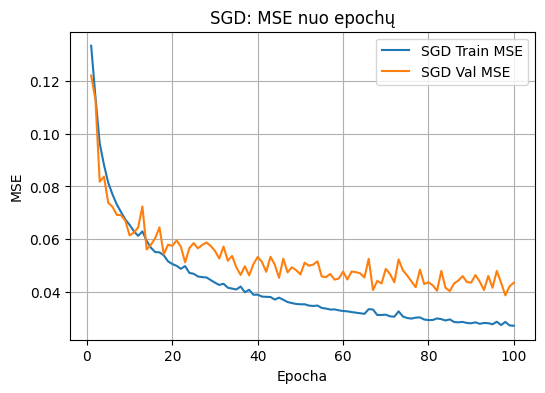

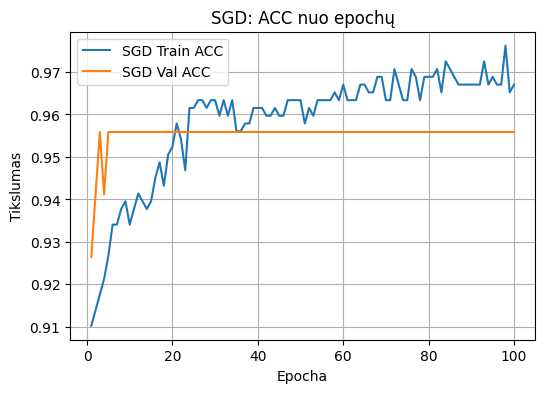

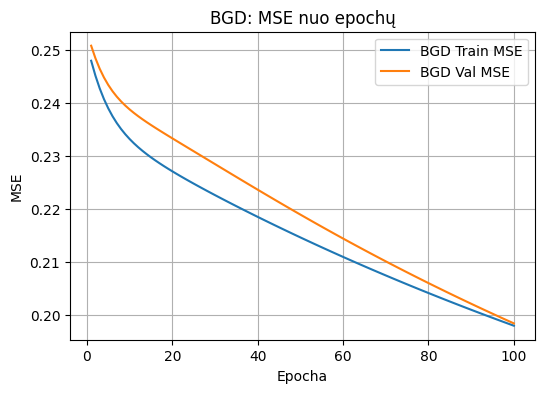

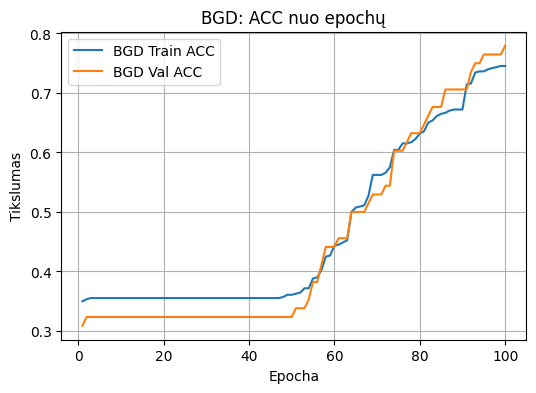

In [39]:
# Grafikai: MSE ir ACC priklausomybė nuo epochų (abiejų metodų)
epochs = np.arange(1, 101)

plt.figure(figsize=(6,4))
plt.plot(epochs, tr_mse_sgd, label="SGD Train MSE")
plt.plot(epochs, va_mse_sgd, label="SGD Val MSE")
plt.title("SGD: MSE nuo epochų"); plt.xlabel("Epocha"); plt.ylabel("MSE")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, tr_acc_sgd, label="SGD Train ACC")
plt.plot(epochs, va_acc_sgd, label="SGD Val ACC")
plt.title("SGD: ACC nuo epochų"); plt.xlabel("Epocha"); plt.ylabel("Tikslumas")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, tr_mse_bgd, label="BGD Train MSE")
plt.plot(epochs, va_mse_bgd, label="BGD Val MSE")
plt.title("BGD: MSE nuo epochų"); plt.xlabel("Epocha"); plt.ylabel("MSE")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, tr_acc_bgd, label="BGD Train ACC")
plt.plot(epochs, va_acc_bgd, label="BGD Val ACC")
plt.title("BGD: ACC nuo epochų"); plt.xlabel("Epocha"); plt.ylabel("Tikslumas")
plt.legend(); plt.grid(True); plt.show()

In [40]:
# --- LR tyrimas su VALIDAVIMO atranka ---
LR_LIST = [0.001, 0.01, 0.1]
grid = []  # sąrašas dict'ų su validavimo metrikomis ir best svoriais

for lr in LR_LIST:
    *_, t, bw, bb, vacc, vmse, bep = train_sgd(X_train, y_train, X_val, y_val, lr=lr)
    grid.append({"method":"SGD","lr":lr,"time":t,"val_acc":vacc,"val_mse":vmse,"best_ep":bep,"w":bw,"b":bb})
    *_, t, bw, bb, vacc, vmse, bep = train_bgd(X_train, y_train, X_val, y_val, lr=lr)
    grid.append({"method":"BGD","lr":lr,"time":t,"val_acc":vacc,"val_mse":vmse,"best_ep":bep,"w":bw,"b":bb})

# --- pasirinkimas pagal VALIDAVIMĄ ---
best = max(grid, key=lambda r: (r["val_acc"], -r["val_mse"]))
print(f"\nGeriausia pagal VALIDAVIMĄ: {best['method']}  LR={best['lr']}  ValACC={best['val_acc']:.4f}  ValMSE={best['val_mse']:.6f}  epocha={best['best_ep']}")

# --- tik dabar: VIENAS TESTAS geriausiam modeliui ---
yprob_best_test = forward(X_test, best["w"], best["b"])
test_mse_best = mse(y_test, yprob_best_test)
test_acc_best = acc(y_test, yprob_best_test)
print(f"TESTAS (geriausio): MSE={test_mse_best:.6f}  ACC={test_acc_best:.4f}")


Geriausia pagal VALIDAVIMĄ: SGD  LR=0.1  ValACC=0.9706  ValMSE=0.026423  epocha=66
TESTAS (geriausio): MSE=0.036659  ACC=0.9420


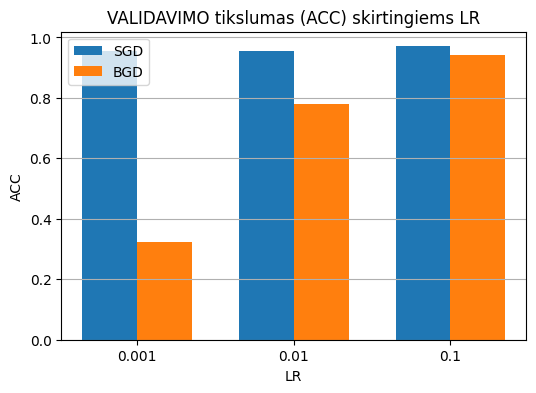

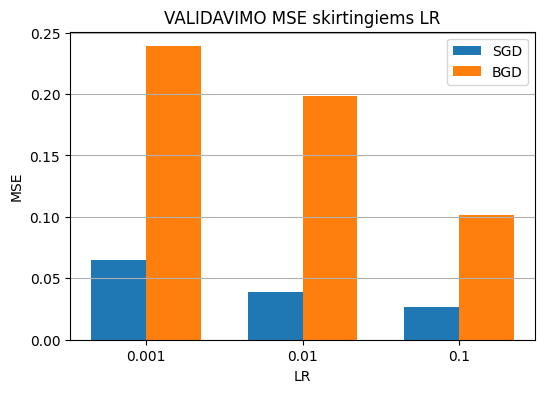

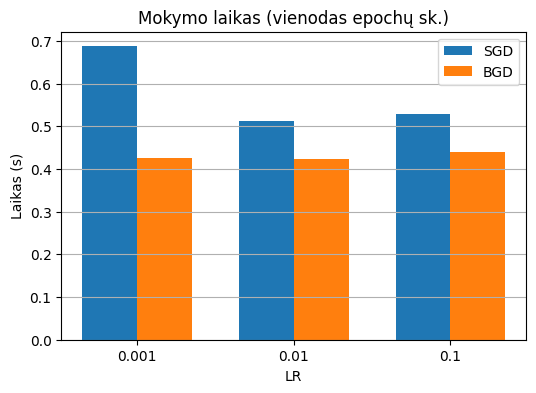

In [41]:
# Paverčiam į vektorius
vals_sgd = [r for r in grid if r["method"]=="SGD"]
vals_bgd = [r for r in grid if r["method"]=="BGD"]
lr_labels = [str(lr) for lr in LR_LIST]

def take(arr, key): return [r[key] for r in arr]

x = np.arange(len(LR_LIST)); width = 0.35

# ACC (validation)
plt.figure(figsize=(6,4))
plt.bar(x - width/2, take(vals_sgd, "val_acc"), width, label="SGD")
plt.bar(x + width/2, take(vals_bgd, "val_acc"), width, label="BGD")
plt.xticks(x, lr_labels); plt.title("VALIDAVIMO tikslumas (ACC) skirtingiems LR")
plt.xlabel("LR"); plt.ylabel("ACC"); plt.legend(); plt.grid(True, axis='y'); plt.show()

# MSE (validation)
plt.figure(figsize=(6,4))
plt.bar(x - width/2, take(vals_sgd, "val_mse"), width, label="SGD")
plt.bar(x + width/2, take(vals_bgd, "val_mse"), width, label="BGD")
plt.xticks(x, lr_labels); plt.title("VALIDAVIMO MSE skirtingiems LR")
plt.xlabel("LR"); plt.ylabel("MSE"); plt.legend(); plt.grid(True, axis='y'); plt.show()

# Laikas
plt.figure(figsize=(6,4))
plt.bar(x - width/2, take(vals_sgd, "time"), width, label="SGD")
plt.bar(x + width/2, take(vals_bgd, "time"), width, label="BGD")
plt.xticks(x, lr_labels); plt.title("Mokymo laikas (vienodas epochų sk.)")
plt.xlabel("LR"); plt.ylabel("Laikas (s)"); plt.legend(); plt.grid(True, axis='y'); plt.show()

In [43]:
# Testavimo įrašų lentelė: SGD ir BGD šalia
def spausdinti_testo_irasus_salia(y_true, yprob_sgd, yprob_bgd):
    y_true = np.asarray(y_true, int)
    yprob_sgd = np.asarray(yprob_sgd, float); ypred_sgd = (yprob_sgd >= 0.5).astype(int)
    yprob_bgd = np.asarray(yprob_bgd, float); ypred_bgd = (yprob_bgd >= 0.5).astype(int)
    n = len(y_true); w = len(str(n))
    fmt = f"{{:>{w}}}  {{:>5}}  {{:>8}}  {{:>9}}  {{:>8}}  {{:>9}}"
    header = fmt.format("#", "tikra", "SGD_prog", "SGD_prob", "BGD_prog", "BGD_prob")
    print(f"\nTesto įrašai (n={n}, slenkstis=0.5):"); print(header); print("-"*len(header))
    for i, (t, ps, pb, pps, ppb) in enumerate(zip(y_true, ypred_sgd, ypred_bgd, yprob_sgd, yprob_bgd), 1):
        print(fmt.format(i, t, ps, f"{pps:.6f}", pb, f"{ppb:.6f}"))

spausdinti_testo_irasus_salia(y_test, yprob_sgd_test, yprob_bgd_test)


Testo įrašai (n=69, slenkstis=0.5):
 #  tikra  SGD_prog   SGD_prob  BGD_prog   BGD_prob
---------------------------------------------------
 1      0         0   0.054940         1   0.508094
 2      0         0   0.082247         0   0.495374
 3      0         0   0.077297         0   0.453305
 4      0         0   0.205155         1   0.545245
 5      1         1   0.998883         1   0.760140
 6      0         0   0.061629         0   0.474609
 7      1         1   0.935896         1   0.654015
 8      0         0   0.077274         0   0.475986
 9      0         0   0.058195         0   0.491342
10      0         0   0.091911         0   0.484669
11      0         0   0.112243         1   0.501178
12      0         0   0.114338         0   0.463312
13      1         1   0.988896         1   0.724650
14      0         0   0.086434         0   0.442712
15      0         0   0.069032         0   0.486679
16      1         1   0.780671         1   0.590491
17      0         0   0.069